- nbp: Carbon Mass Flux out of Atmosphere Due to Net Biospheric Production on Land [kgC m-2 s-1] [kg m-2 s-1]
- fgco2: Surface Downward Mass Flux of Carbon as CO2 [kgC m-2 s-1] [kg m-2 s-1]
- ra: Carbon Mass Flux into Atmosphere Due to Autotrophic (Plant) Respiration on Land [kgC m-2 s-1] [kg m-2 s-1]
- rh: Total Heterotrophic Respiration on Land as Carbon Mass Flux [kgC m-2 s-1] [kg m-2 s-1]
- gpp: Carbon Mass Flux out of Atmosphere Due to Gross Primary Production on Land [kgC m-2 s-1] [kg m-2 s-1]
- fFire: Carbon Mass Flux into Atmosphere Due to CO2 Emission from Fire Excluding Land-Use Change [kgC m-2 s-1] [kg m-2 s-1]

In [1]:
# to set
r_sulfur =  ['12', 
             '13', 
             '14']
r_over =  ['1', 
           '2', 
           '3'
          ]
end_I = 2062
end_II = 2150
end_III = 2249

In [2]:
%matplotlib inline
import xarray as xr
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import nc_time_axis 
import cftime

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit 

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import proplot as pplt

import warnings
warnings.filterwarnings('ignore')

/data/softs/anaconda3-2020.07/envs/gloenv_py3.9/lib/python3.9/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [3]:
dir_NER = f'..'
dir_hist = f'{dir_NER}historical/'
dir_piControl=f'{dir_NER}piControl/'
dir_sulfur = f'{dir_NER}ssp534-sulfur/'
dir_over = f'{dir_NER}ssp534-over/'

In [5]:
scens = ['ssp534-sulfur', 'ssp534-over']
params = ['fgco2', 'nbp', 'rh', 'ra', 'gpp', 'fFire']
nb_cs_params = len(params) 

In [6]:
#load in data
# turn from monthly mean to yearly average
# merge with historical data for smooth 10 year rolling mean
data = dict()
over=dict()
over_var=dict()
sulf=dict()
sulf_var=dict()
    
for exp in ['ssp126', 'ssp534-over', 'historical', 'ssp534-sulfur']:
    if exp == 'ssp534-over':
        ds =[]
        for i in range(0, nb_cs_params):
            for mem in r_over:
                over[f'{params[i]}_{mem}'] = xr.open_mfdataset(f'{dir_over}CNRM-ESM2-1_ssp534-over_r{mem}i1p1f2/merged/{params[i]}_*mon_CNRM-ESM2-1_{exp}_r{mem}i1p1f2_*_201501-224912.nc'
                                           , engine="netcdf4").groupby('time.year').mean('time')
            data[f'{params[i]}_{exp}'] = xr.concat([over[f'{params[i]}_1'], over[f'{params[i]}_2'], over[f'{params[i]}_3']], dim='member')
        
    
# load in historic data to get smooth 10year rolling mean at the start of the future simulations
    elif exp == 'historical':
        ds =[]
        for i in range(0, nb_cs_params):
            data[f'{params[i]}_{exp}'] = xr.open_mfdataset(f'{dir_NER}historical/{params[i]}_*_g*_185001-201412.nc'
                                    , engine="netcdf4").drop('time_bounds').groupby('time.year').mean('time')

    elif exp == 'ssp534-sulfur':
        ds=[]
        for i in range(0, nb_cs_params):
            for mem in r_sulfur:
                sulf[f'{params[i]}_{mem}'] = xr.open_mfdataset(f'{dir_sulfur}CNRM-ESM2-1_ssp534-over_r{mem}i1p1f2*/merged/{params[i]}_*mon_CNRM-ESM2-1_{exp}_r{mem}i1p1f2_*_201501-224912.nc'
                                           , engine="netcdf4").groupby('time.year').mean('time')
            data[f'{params[i]}_{exp}'] = xr.concat([sulf[f'{params[i]}_12'], sulf[f'{params[i]}_13'], sulf[f'{params[i]}_14']], dim='member')

        

# data['ssp534'] = xr.merge([over_ssp534, hist])
# data['sulfur']= xr.merge([over_sulfur, hist])



In [7]:
# piControl

data['fgco2_piControl'] = xr.open_mfdataset(f'{dir_piControl}fgco2_Omon_*_g*_185001-234912.nc'
                                                             , engine="netcdf4").mean('time')
data['nbp_piControl'] = xr.open_mfdataset(f'{dir_piControl}nbp_Lmon_*_g*_185001-234912.nc'
                                                             , engine="netcdf4").mean('time')


# area data
areacello = xr.open_mfdataset(f'{archive}CNRM_runs/areacello*.nc'
                                                             , engine="netcdf4")
areacella = xr.open_mfdataset(f'{archive}CNRM_runs/areacella*.nc'
                                                             , engine="netcdf4")
sftlf =  xr.open_dataset(f'{scratch}/LUC_file_IMAGE/sftlf_fx_CNRM-ESM2-1_historical_r2i1p1f2_gr.nc',
                                    engine="netcdf4")

#### Add historical for smooth rolling mean

In [9]:
for scen in scens:
    for param in params:
        data[f'{param}_{scen}_long'] = xr.merge([data[f'{param}_{scen}'].mean('member'), data[f'{param}_historical']])

In [10]:
SAI = pd.read_csv(f'{scratch}/NER_analysis/data/aod_times2_5.csv').drop({'Unnamed: 0'}, axis=1)

In [11]:
co2_fut = xr.open_mfdataset(f'{dir_sulfur}CNRM-ESM2-1_ssp534-over_r12i1p1f2*/merged/co2_Amon_*_g*_201501-224912.nc'
                            , engine="netcdf4").groupby('time.year').mean('time')
#co2_hist = xr.open_mfdataset(f'{dir_hist}co2_Amon_*_g*_185001-201412.nc'
                                                #             , engine="netcdf4").groupby('time.year').mean('time')

#co2 = xr.merge([co2_fut, co2_hist])
# select surface pressure levels and convert to ppm
co2_ = co2_fut.sel(plev=slice(100000, 70000)).mean('plev').mean(('lat', 'lon')) * 1000000

In [12]:
# Calculate sink in GtC/yr
land=dict()
ocean=dict()
gpp=dict()
ra=dict()
rh=dict()
fire=dict()


for scen in scens:
    land[scen] = (areacella['areacella'].where(sftlf['sftlf']>50)*data[f'nbp_{scen}_long']*3600*365*24/1e12).sum(('lat', 'lon')).rolling(year=10).mean().sel(year=slice(2015,2249)).load()
    ocean[scen] = (areacello['areacello']*data[f'fgco2_{scen}_long']*3600*365*24/1e12).sum(('y', 'x')).rolling(year=10).mean().sel(year=slice(2015,2249)).load()   
    gpp[scen] = (areacella['areacella'].where(sftlf['sftlf']>50)*data[f'gpp_{scen}_long']*3600*365*24/1e12).sum(('lat', 'lon')).rolling(year=10).mean().sel(year=slice(2015,2249)).load()
    ra[scen] = (areacella['areacella'].where(sftlf['sftlf']>50)*data[f'ra_{scen}_long']*3600*365*24/1e12).sum(('lat', 'lon')).rolling(year=10).mean().sel(year=slice(2015,2249)).load()
    rh[scen] = (areacella['areacella'].where(sftlf['sftlf']>50)*data[f'rh_{scen}_long']*3600*365*24/1e12).sum(('lat', 'lon')).rolling(year=10).mean().sel(year=slice(2015,2249)).load()
    fire[scen] = (areacella['areacella'].where(sftlf['sftlf']>50)*data[f'fFire_{scen}_long']*3600*365*24/1e12).sum(('lat', 'lon')).rolling(year=10).mean().sel(year=slice(2015,2249)).load()
    
    
    
land['piControl'] = (areacella['areacella'].where(sftlf['sftlf']>50)*data[f'nbp_piControl']*3600*365*24/1e12).sum(('lat', 'lon')).load()
ocean['piControl'] = (areacello['areacello']*data[f'fgco2_piControl']*3600*365*24/1e12).sum(('y', 'x')).load()    

In [13]:
# subtract piControl sink from sinks -> to only get anthropogenic sinks/sources
land_pi=dict()
ocean_pi=dict()

for scen in ['ssp534-over', 'ssp534-sulfur']:
    land_pi[scen] = land[scen]-land['piControl']
    ocean_pi[scen] = ocean[scen]-ocean['piControl']

In [14]:
disturb = dict()
nep = dict()

for scen in ['ssp534-over', 'ssp534-sulfur']:
    nep[scen] = gpp[scen]['gpp'] - ra[scen]['ra'] - rh[scen]['rh']
    disturb[scen] = (gpp[scen]['gpp'] - ra[scen]['ra'] - rh[scen]['rh']) - land[scen]['nbp']

In [15]:
land_diff = land['ssp534-sulfur'] - land['ssp534-over']
ocean_diff = ocean['ssp534-sulfur'] - ocean['ssp534-over']
gpp_diff = gpp['ssp534-sulfur'] - gpp['ssp534-over']
ra_diff = ra['ssp534-sulfur'] - ra['ssp534-over']
rh_diff = rh['ssp534-sulfur'] - rh['ssp534-over']
fire_diff = fire['ssp534-sulfur'] - fire['ssp534-over']
nep_diff = nep['ssp534-sulfur'] - nep['ssp534-over']
disturb_diff = disturb['ssp534-sulfur'] - disturb['ssp534-over']

In [16]:
# cumulative nbp
land_pi_cum = dict()
ocean_pi_cum = dict()

for scen in ['ssp534-over', 'ssp534-sulfur']:
    land_pi_cum[scen] = land_pi[scen]['nbp'].cumsum()
    ocean_pi_cum[scen] = ocean_pi[scen]['fgco2'].cumsum()    

# Cumulative sink values in the 3 phases

In [17]:
phase_I=dict()
phase_II=dict()
phase_III=dict()


for scen in scens:
    for i in ['land', 'ocean']:
        if i == 'land':
            df = land_pi
        elif i == 'ocean':
            df = ocean_pi

        phase_I[f'{i}_{scen}'] = df[scen].sel(year=slice(2015, end_I))
        phase_II[f'{i}_{scen}'] = df[scen].sel(year=slice(end_I, end_II))
        phase_III[f'{i}_{scen}'] = df[scen].sel(year=slice(end_II, end_III))

In [18]:
cum_C = dict()

for scen in scens:
    for i in ['land', 'ocean']:
        if i == 'land':
            var = 'nbp'
        elif i == 'ocean':
            var = 'fgco2'
        cum_C[f'{i}_{scen}_I'] = round(phase_I[f'{i}_{scen}'][var].sum().values.item(), 1)
        cum_C[f'{i}_{scen}_II'] = round(phase_II[f'{i}_{scen}'][var].sum().values.item(), 1)
        cum_C[f'{i}_{scen}_III'] = round(phase_III[f'{i}_{scen}'][var].sum().values.item(), 1)

In [19]:
for p in ['I', 'II', 'III']:
    cum_C[f'land_diff_{p}'] = cum_C[f'land_ssp534-sulfur_{p}'] - cum_C[f'land_ssp534-over_{p}']
    cum_C[f'ocean_diff_{p}'] = cum_C[f'ocean_ssp534-sulfur_{p}'] - cum_C[f'ocean_ssp534-over_{p}']
    cum_C[f'total_diff_{p}'] = (cum_C[f'land_ssp534-sulfur_{p}'] + cum_C[f'ocean_ssp534-sulfur_{p}']) - (cum_C[f'land_ssp534-over_{p}'] + cum_C[f'ocean_ssp534-over_{p}'])
cum_C[f'land_all'] = cum_C[f'land_diff_I'] + cum_C[f'land_diff_II'] + cum_C[f'land_diff_III']
cum_C[f'ocean_all'] = cum_C[f'ocean_diff_I'] + cum_C[f'ocean_diff_II'] + cum_C[f'ocean_diff_III']
cum_C[f'total_all'] = cum_C[f'total_diff_I'] + cum_C[f'total_diff_II'] + cum_C[f'total_diff_III']

In [35]:
cum_C[f'total_all']

16.70000000000001

# Big plots

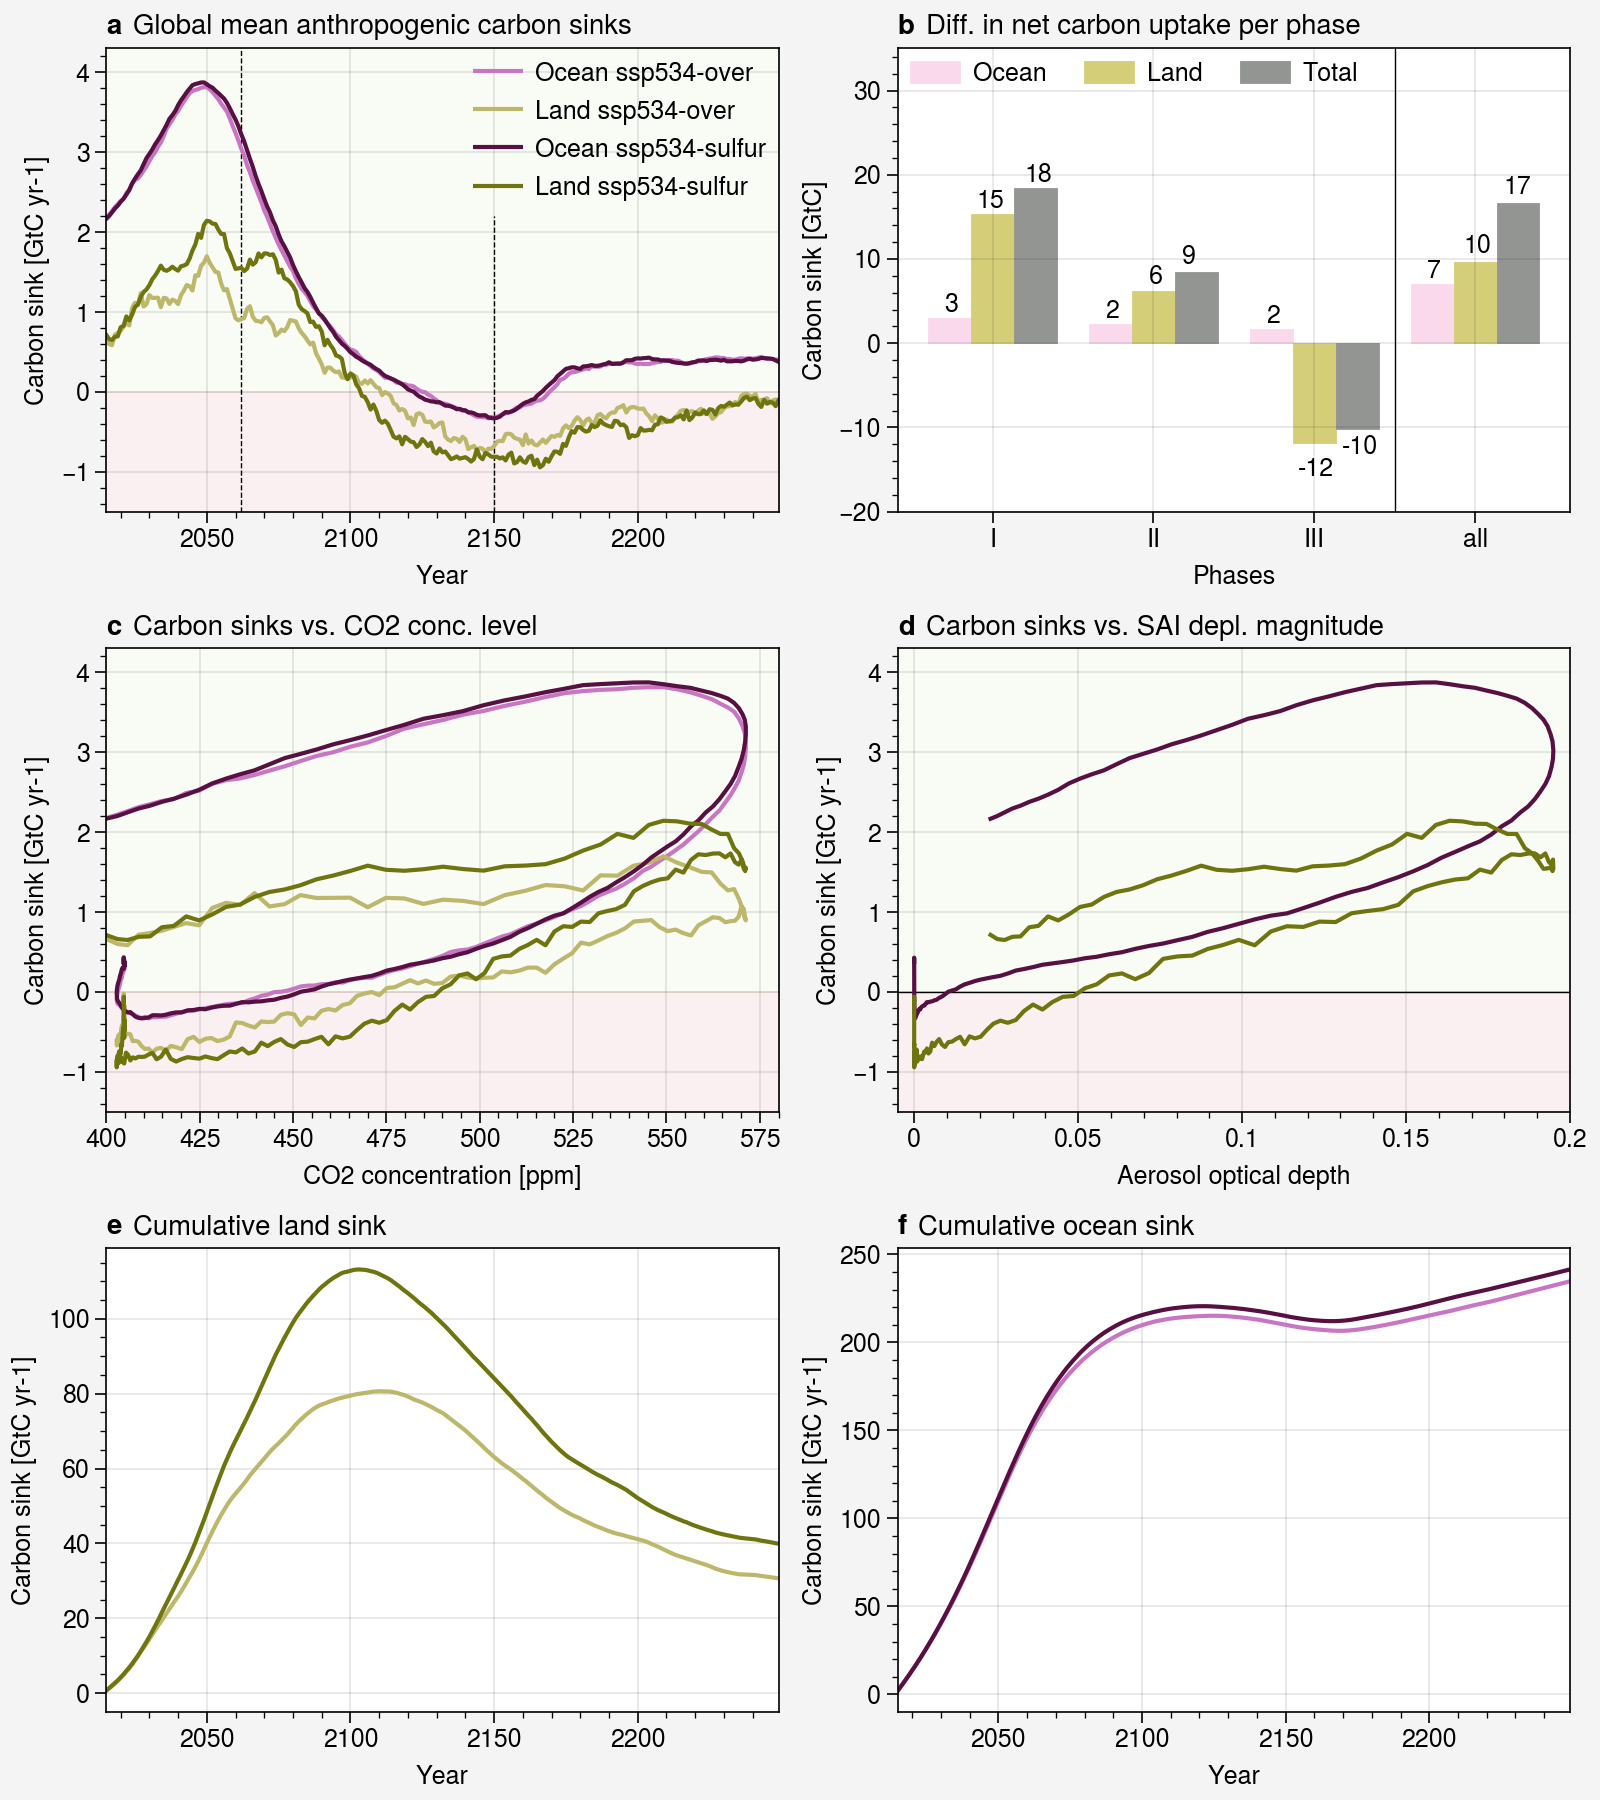

In [36]:
#fig, axs = pplt.subplots(figsize=(4, 2.5))

fig, axs = pplt.subplots(ncols=2, nrows=3, refwidth=1.7, figsize=(8, 9), sharey=False, sharex=False)


# Global mean anthropgenic carbon sinks
axs[0].fill_between(list(range(2015, 2249+1)),0, 4.3, color='pale olive', alpha=0.08)
axs[0].fill_between(list(range(2015, 2249+1)),0, -1.5, color='faded red', alpha=0.08)

axs[0].vlines(2062,-1.5, 4.3, lw = 0.5, ls = '--', color='black')
axs[0].vlines(2150,-1.5, 2.2, lw = 0.5, ls = '--', color='black')

axs[0].plot(np.arange(2015,2249+1),ocean_pi['ssp534-over']['fgco2'], color='orchid', label='Ocean ssp534-over')
axs[0].plot(np.arange(2015,2249+1),land_pi['ssp534-over']['nbp'],  color='darkkhaki', label='Land ssp534-over')
axs[0].plot(np.arange(2015,2249+1),ocean_pi['ssp534-sulfur']['fgco2'], color='plum', label='Ocean ssp534-sulfur')
axs[0].plot(np.arange(2015,2249+1),land_pi['ssp534-sulfur']['nbp'], color='olive', label='Land ssp534-sulfur')

#axs[0].fill_between(list(range(1850, 2249+1)),1.9, 2.1, color='lightgray')
axs[0].legend(ncol=1, frameon=False)
axs[0].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Carbon sink [GtC yr-1]',# ylim=(0.5, 3), xlim=(2015, 2250)
    title='Global mean anthropogenic carbon sinks', titleloc='l'
)



# barplot
cycle = pplt.Cycle('plum', 'darkkhaki', 'grey', N=3, alpha=1)
cols = ['I', 'II', 'III','all']
data_ = [
    [cum_C[f'ocean_diff_I'], cum_C[f'land_diff_I'], cum_C[f'total_diff_I']],
    [cum_C[f'ocean_diff_II'], cum_C[f'land_diff_II'], cum_C[f'total_diff_II']],
    [cum_C[f'ocean_diff_III'], cum_C[f'land_diff_III'], cum_C[f'total_diff_III']],
    [cum_C[f'ocean_all'], cum_C[f'land_all'], cum_C[f'total_all']]
]
axs[1].bar(cols, data_, cycle=cycle, alpha=1, labels=['Ocean', 'Land', 'Total'])

axs[1].format(title='Diff. in net carbon uptake per phase', titleloc='l', 
              xlabel='Phases', ylabel='Carbon sink [GtC]', ylim=(-20,35))
axs[1].legend(frameon=False, loc='ul')

axs[1].text(-0.3,3.7,'3')
axs[1].text(-0.1,16.1,'15')
axs[1].text( 0.2,19.1,'18')

axs[1].text( 0.7,3,'2')
axs[1].text( 0.97,7,'6')
axs[1].text( 1.175,9.4,'9')

axs[1].text( 1.7,2.4,'2')
axs[1].text( 1.9,-15.8,'-12')
axs[1].text( 2.17,-13.1,'-10')

axs[1].text( 2.7,7.7,'7')
axs[1].text( 2.93,10.7,'10')
axs[1].text( 3.175,17.7,'17')


axs[1].vlines(2.5,-30, 35, lw = 0.5, ls = '-', color='black')
axs[3].hlines(0,-0.5, 3.5, lw = 0.5, color='black')



# carbon sinks with co2 concentration
axs[2].fill_between(list(range(400, 580+1)),0, 4.3, color='pale olive', alpha=0.08)
axs[2].fill_between(list(range(400, 580+1)),0, -1.5, color='faded red', alpha=0.08)

axs[2].plot(co2_['co2'],ocean_pi['ssp534-over']['fgco2'], color='orchid', )
axs[2].plot(co2_['co2'],land_pi['ssp534-over']['nbp'], color='darkkhaki', )
axs[2].plot(co2_['co2'],ocean_pi['ssp534-sulfur']['fgco2'],  color='plum' )
axs[2].plot(co2_['co2'],land_pi['ssp534-sulfur']['nbp'],  color='olive' )

axs[2].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='CO2 concentration [ppm]', ylabel='Carbon sink [GtC yr-1]', xlim=(400, 580),
    title='Carbon sinks vs. CO2 conc. level', titleloc='l'
)


# carbon sinks with SAI
axs[3].fill_between(list(range(-1,1+1)),0, 4.3, color='pale olive', alpha=0.08)
axs[3].fill_between(list(range(-1,1+1)),0, -1.5, color='faded red', alpha=0.08)

axs[3].plot(SAI['AOD'],ocean_pi['ssp534-sulfur']['fgco2'], label='ocean sink', color='plum' )
axs[3].plot(SAI['AOD'],land_pi['ssp534-sulfur']['nbp'], label='land sink', color='olive' )

axs[3].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Aerosol optical depth', ylabel='Carbon sink [GtC yr-1]', xlim=(-0.005, 0.2),
    title='Carbon sinks vs. SAI depl. magnitude', titleloc='l'
)



# cum land sink
axs[4].plot(np.arange(2015,2249+1),land_pi_cum['ssp534-over'], color='darkkhaki', label ='ssp534-over')
axs[4].plot(np.arange(2015,2249+1),land_pi_cum['ssp534-sulfur'],  color='olive',label ='ssp534-sulfur')

axs[4].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Carbon sink [GtC yr-1]',
    title='Cumulative land sink', titleloc='l'
)


# cum ocean sink
axs[5].plot(np.arange(2015,2249+1),ocean_pi_cum['ssp534-over'], color='orchid', label ='ssp534-over')
axs[5].plot(np.arange(2015,2249+1),ocean_pi_cum['ssp534-sulfur'],  color='plum',label ='ssp534-sulfur')

axs[5].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Carbon sink [GtC yr-1]',
    title='Cumulative ocean sink', titleloc='l'
)




fig.format(abc=True)

# save
save_name = f'carbon_sink_figure.png'
save_dir = f'{scratch}/NER_analysis/plots/' 
#pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True) 
fig.savefig(save_dir + save_name, dpi=600)

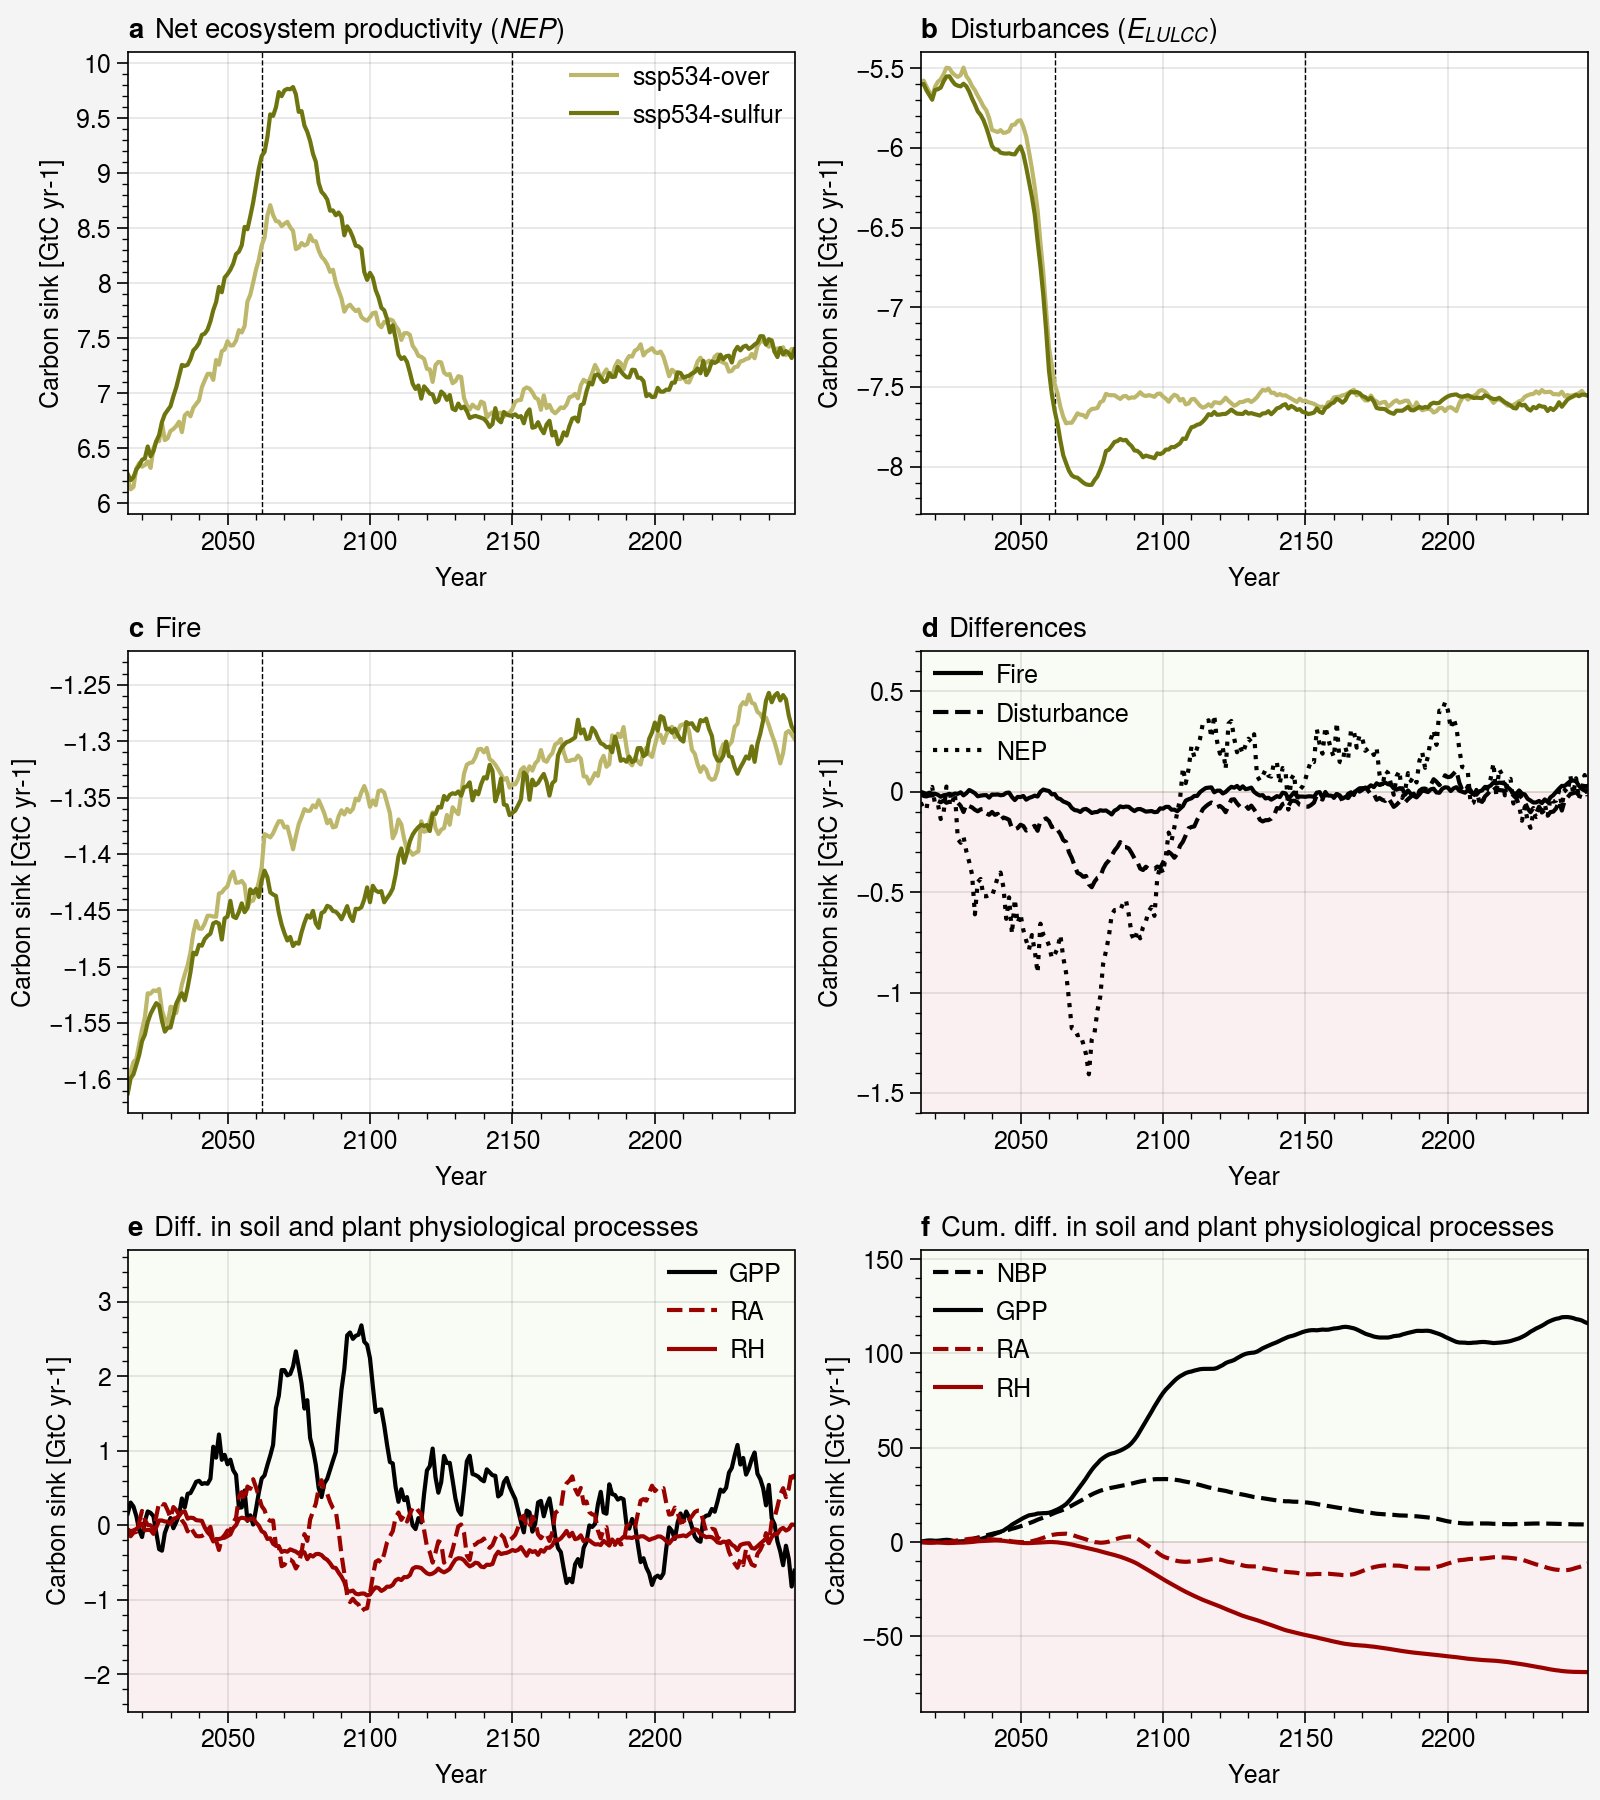

In [22]:
fig, axs = pplt.subplots(ncols=2, nrows=3, refwidth=1.7, figsize=(8, 9), sharey=False, sharex=False)



# Net ecosystem productivty
axs[0].vlines(2062,5.9, 10.1, lw = 0.5, ls = '--', color='black')
axs[0].vlines(2150,5.9, 10.1, lw = 0.5, ls = '--', color='black')

axs[0].plot(np.arange(2015,2249+1),nep['ssp534-over'], color='darkkhaki', label='ssp534-over')
axs[0].plot(np.arange(2015,2249+1),nep['ssp534-sulfur'],  color='olive', label='ssp534-sulfur')


axs[0].legend(ncol=1, frameon=False)
axs[0].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Carbon sink [GtC yr-1]',# ylim=(0.5, 3), xlim=(2015, 2250)
    title=r'Net ecosystem productivity ($NEP$)', titleloc='l'
)



# Disturbances
axs[1].vlines(2062,-8.3, -5.4, lw = 0.5, ls = '--', color='black')
axs[1].vlines(2150,-8.3, -5.4, lw = 0.5, ls = '--', color='black')

axs[1].plot(np.arange(2015,2249+1),disturb['ssp534-over']*-1, color='darkkhaki', label='ssp534-over')
axs[1].plot(np.arange(2015,2249+1),disturb['ssp534-sulfur']*-1,  color='olive', label='ssp534-sulfur')

axs[1].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Carbon sink [GtC yr-1]',# ylim=(0.5, 3), xlim=(2015, 2250)
    title=r'Disturbances ($E_{LULCC}$)', titleloc='l'
)


# Fire
axs[2].vlines(2062,-1.63, -1.22, lw = 0.5, ls = '--', color='black')
axs[2].vlines(2150,-1.63, -1.22, lw = 0.5, ls = '--', color='black')

axs[2].plot(np.arange(2015,2249+1),fire['ssp534-over']['fFire']*-1, color='darkkhaki', label='ssp534-over')
axs[2].plot(np.arange(2015,2249+1),fire['ssp534-sulfur']['fFire']*-1,  color='olive', label='ssp534-sulfur')


axs[2].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Carbon sink [GtC yr-1]',
    title='Fire', titleloc='l'
)


#Differences
axs[3].fill_between(np.arange(2015,2249+1),0, 0.7, color='pale olive', alpha=0.08)
axs[3].fill_between(np.arange(2015,2249+1),0, -1.6, color='faded red', alpha=0.08)

axs[3].plot(np.arange(2015,2249+1),fire_diff['fFire']*-1,  color='black', label='Fire')
axs[3].plot(np.arange(2015,2249+1),disturb_diff*-1,  color='black', ls='--',label='Disturbance')
axs[3].plot(np.arange(2015,2249+1),nep_diff*-1,  color='black', ls=':', label='NEP')



axs[3].legend(ncol=1, frameon=False)

axs[3].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Carbon sink [GtC yr-1]',
    title='Differences', titleloc='l'
)

# GPP, RA and RH
axs[4].fill_between(np.arange(2015,2249+1),0, 3.7, color='pale olive', alpha=0.08)
axs[4].fill_between(np.arange(2015,2249+1),0, -2.5, color='faded red', alpha=0.08)

axs[4].plot(np.arange(2015,2249+1),gpp_diff['gpp'], color='black', label='GPP')
axs[4].plot(np.arange(2015,2249+1),ra_diff['ra']*-1, color='deep red', label='RA', ls='--')
axs[4].plot(np.arange(2015,2249+1),rh_diff['rh']*-1, color='deep red', label='RH')

axs[4].legend(ncol=1, frameon=False)

axs[4].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Carbon sink [GtC yr-1]',
    title='Diff. in soil and plant physiological processes', titleloc='l'
)

# Cumualtive GPP, RA and RH
axs[5].fill_between(np.arange(2015,2249+1),0, 155, color='pale olive', alpha=0.08)
axs[5].fill_between(np.arange(2015,2249+1),0, -90, color='faded red', alpha=0.08)

axs[5].plot(np.arange(2015,2249+1),land_diff['nbp'].cumsum(), color='black', ls='--', label='NBP')
axs[5].plot(np.arange(2015,2249+1),gpp_diff['gpp'].cumsum(), color='black', label='GPP')
axs[5].plot(np.arange(2015,2249+1),ra_diff['ra'].cumsum()*-1, color='deep red', ls='--', label='RA')
axs[5].plot(np.arange(2015,2249+1),rh_diff['rh'].cumsum()*-1, color='deep red', label='RH')

axs[5].legend(ncol=1, frameon=False)

axs[5].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Carbon sink [GtC yr-1]',
    title='Cum. diff. in soil and plant physiological processes', titleloc='l'
)



#fig.delaxes(axs[5])


fig.format(abc=True)

# save
save_name = f'land_figure.png'
save_dir = f'{scratch}/NER_analysis/plots/' 
#pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True) 
fig.savefig(save_dir + save_name, dpi=600)